<a href="https://colab.research.google.com/github/shanikairoshi/QFL-with-DUN/blob/main/DeepUnfoldQFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorcircuit

In [2]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import jax
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rc('font', size=14)

key = jax.random.PRNGKey(42)
tf.random.set_seed(42)

In [3]:
dataset = 'mnist'
# dataset = 'fashion'
readout_mode = 'softmax'
# readout_mode = 'sample'
encoding_mode = 'vanilla'
# encoding_mode = 'mean'
# encoding_mode = 'half'

In [4]:
n = 8
n_node = 8

In [5]:
K = tc.set_backend('jax')

In [6]:
# numpy data
if dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
elif dataset == 'fashion':
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
ind = y_test == 9
x_test, y_test = x_test[~ind], y_test[~ind]
ind = y_test == 8
x_test, y_test = x_test[~ind], y_test[~ind]
ind = y_train == 9
x_train, y_train = x_train[~ind], y_train[~ind]
ind = y_train == 8
x_train, y_train = x_train[~ind], y_train[~ind]

x_train = x_train / 255.0
if encoding_mode == 'vanilla':
    mean = 0
elif encoding_mode == 'mean':
    mean = jnp.mean(x_train, axis=0)
elif encoding_mode == 'half':
    mean = 0.5
x_train = x_train - mean
x_train = tf.image.resize(x_train[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_train = x_train / jnp.sqrt(jnp.sum(x_train**2, axis=-1, keepdims=True))

x_test = x_test / 255.0
x_test = x_test - mean
x_test = tf.image.resize(x_test[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_test = x_test / jnp.sqrt(jnp.sum(x_test**2, axis=-1, keepdims=True))
y_test = jax.nn.one_hot(y_test, n_node)

def filter_pair(x, y, a, b):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    y = jax.nn.one_hot(y, n_node)
    return x, y

In [7]:
#quantum circuit function
def clf(params, c, k): #params; a set of parameters, c; quantum circuit, k;a numebr of layers
    for j in range(k): #Each layer structure define
        for i in range(n - 1):
            c.cnot(i, i + 1) #series of  CNOT gates to create entanglement between neighboring qubits
        for i in range(n):
          #It applies a set of single-qubit rotations (rx and rz gates)
          #to each qubit based on the parameters provided in the params array
            c.rx(i, theta=params[3 * j, i])
            c.rz(i, theta=params[3 * j + 1, i])
            c.rx(i, theta=params[3 * j + 2, i])
    return c


#a logit typically refers to
#the raw, unnormalized output of a model before it undergoes a final transformation into probabilities.
def readout(c):#takes a quntum circuit as input
  #If readout_mode is set to 'softmax', it calculates the logits for
  #each qubit's state using the Pauli-Z operator and then applies a
  #softmax function to obtain probabilities.
    if readout_mode == 'softmax':
        logits = []
        for i in range(n_node):
            logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
        logits = jnp.stack(logits, axis=-1) * 10
        probs = jax.nn.softmax(logits)
    elif readout_mode == 'sample':
        wf = jnp.abs(c.wavefunction()[:n_node])**2
        probs = wf / jnp.sum(wf)
    return probs

def pred(params, x, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return probs
pred = K.vmap(pred, vectorized_argnums=[1])

In [8]:
def pred(params, x, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return probs
pred = K.vmap(pred, vectorized_argnums=[1])

In [9]:
def loss(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return -jnp.mean(jnp.sum(y * jnp.log(probs + 1e-7), axis=-1))
loss = K.jit(loss, static_argnums=[3])

In [10]:
def accuracy(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return jnp.argmax(probs, axis=-1) == jnp.argmax(y, axis=-1)
accuracy = K.jit(accuracy, static_argnums=[3])

In [11]:
k = 20 #48

In [12]:
compute_loss = K.jit(K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2]), static_argnums=[3])
compute_accuracy = K.jit(K.vmap(accuracy, vectorized_argnums=[1, 2]), static_argnums=[3])

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0, batch 0/100, loss 2.1650826930999756, accuracy 0.185546875
Epoch 0, batch 10/100, loss 1.9430322647094727, accuracy 0.263671875
Epoch 1, batch 0/100, loss 1.8121978044509888, accuracy 0.3173828125
Epoch 1, batch 10/100, loss 1.5842697620391846, accuracy 0.48046875
Epoch 2, batch 0/100, loss 1.479067325592041, accuracy 0.5185546875
Epoch 2, batch 10/100, loss 1.4324110746383667, accuracy 0.52734375
Epoch 3, batch 0/100, loss 1.354995608329773, accuracy 0.5830078125
Epoch 3, batch 10/100, loss 1.3095881938934326, accuracy 0.5986328125
Epoch 4, batch 0/100, loss 1.2864768505096436, accuracy 0.623046875
Epoch 4, batch 10/100, loss 1.2930033206939697, accuracy 0.599609375


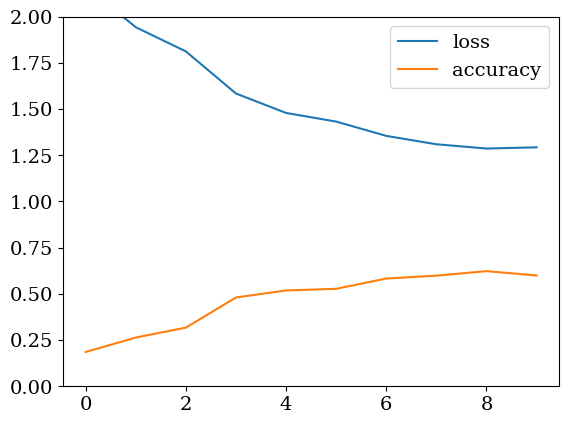

In [32]:

params_list = []
opt_state_list = []
data_list = []
iter_list = []
for node in tqdm(range(n_node-1)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    data = tf.data.Dataset.from_tensor_slices((x_train_node, y_train_node)).batch(16)
    data_list.append(data)
    iter_list.append(iter(data))

    key, subkey = jax.random.split(key)
    params = jax.random.normal(subkey, (3 * k, n))
    opt = optax.adam(learning_rate=1e-2)
    opt_state = opt.init(params)
    params_list.append(params)
    opt_state_list.append(opt_state)


loss_listfedavg = []
acc_listfedavg = []
for e in tqdm(range(5), leave=False):
    for b in range(20):
        for node in range(n_node-1):
            try:
                x, y = next(iter_list[node])
            except StopIteration:
                iter_list[node] = iter(data_list[node])
                x, y = next(iter_list[node])
            x = x.numpy()
            y = y.numpy()
            loss_val, grad_val = compute_loss(params_list[node], x, y, k)
            updates, opt_state_list[node] = opt.update(grad_val, opt_state_list[node], params_list[node])
            params_list[node] = optax.apply_updates(params_list[node], updates)

        avg_params = jnp.mean(jnp.stack(params_list, axis=0), axis=0)
        for node in range(n_node-1):
            params_list[node] = avg_params

        if b % 10 == 0:
            avg_loss = jnp.mean(compute_loss(avg_params, x_test[:1024], y_test[:1024], k)[0])
            loss_listfedavg.append(avg_loss)
            acc_listfedavg.append(compute_accuracy(avg_params, x_test[:1024], y_test[:1024], k).mean())
            print(f"Epoch {e}, batch {b}/{100}, loss {avg_loss}, accuracy {acc_listfedavg[-1]}")



plt.plot(loss_listfedavg)
plt.plot(acc_listfedavg)
plt.legend(['loss', 'accuracy'])
plt.ylim(0, 2)
plt.show()




In [ ]:
plt.plot(loss_listfedavg)
plt.plot(acc_listfedavg)
plt.legend(['loss', 'accuracy'])
plt.ylim(0, 4)
plt.show()



In [33]:
# prompt: save loss_listfedavg anc accuracy_listfedavg to .csv

import csv

with open('loss_listfedavg.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(loss_listfedavg)

with open('accuracy_listfedavg.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(acc_listfedavg)


In [ ]:
plt.plot(loss_listfedavg)
plt.plot(acc_listfedavg)
plt.legend(['loss', 'accuracy'])
plt.ylim(0, 4)
plt.show()

In [ ]:

params_list = [] #store parameters
opt_state_list = []#optimization states
data_list = []#datasets
iter_list = []#iterators for each node

for node in tqdm(range(n_node-1)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    data = tf.data.Dataset.from_tensor_slices((x_train_node, y_train_node)).batch(128)
    data_list.append(data)
    iter_list.append(iter(data)) #The iterator is used to iterate over batches during the training loop.

    key, subkey = jax.random.split(key)
    params = jax.random.normal(subkey, (3 * k, n))
    opt = optax.adam(learning_rate=1e-2)
    opt_state = opt.init(params)
    params_list.append(params)
    opt_state_list.append(opt_state)

loss_list = []
acc_list = []
for e in tqdm(range(5), leave=False):
    for b in range(100): #number of batches one include 16 data points
        for node in range(n_node-1):
            try:
                x, y = next(iter_list[node])
            except StopIteration:
                iter_list[node] = iter(data_list[node])
                x, y = next(iter_list[node])
            x = x.numpy()
            y = y.numpy()
            loss_val, grad_val = compute_loss(params_list[node], x, y, k)
            updates, opt_state_list[node] = opt.update(grad_val, opt_state_list[node], params_list[node])
            params_list[node] = optax.apply_updates(params_list[node], updates)

        avg_params = jnp.mean(jnp.stack(params_list, axis=0), axis=0)
        for node in range(n_node-1):
            params_list[node] = avg_params

        if b % 25 == 0:
            avg_loss = jnp.mean(compute_loss(avg_params, x_test[:1024], y_test[:1024], k)[0])
            loss_list.append(avg_loss)
            acc_list.append(compute_accuracy(avg_params, x_test[:1024], y_test[:1024], k).mean())
            print(f"Epoch {e}, batch {b}/{100}, loss {avg_loss}, accuracy {acc_list[-1]}")



DEEP UNFOLDING APPLY

In [14]:
#def deepUnfoldweights(deepunfold_iterations,quibits):

M=2 #deep unfolded layers
i=0
#key = jax.random.PRNGKey(0)
n=8

#compute_lossdeep = K.jit(K.vectorized_value_and_grad(deeploss, vectorized_argnums=[1, 2]), static_argnums=[3])

for loop in range (M):
  i=i+1
  print("Start deep unfolding layer", {loop})
  params_list = [] #store parameters
  opt_state_list = []#optimization states
  data_list = []#datasets
  iter_list = []#iterators for each node
  opt_state_lists=[]

  for node in tqdm(range(n_node)):
    #print("Assign data and parameter initialization", {node})
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    data = tf.data.Dataset.from_tensor_slices((x_train_node, y_train_node)).batch(64)
    data_list.append(data)
    iter_list.append(iter(data)) #The iterator is used to iterate over batches during the training loop.

    key, subkey = jax.random.split(key)
    params = jax.random.normal(subkey, (3 * k, n))
    opt = optax.adam(learning_rate=1e-2)

    opt_state = opt.init(params)
    params_list.append(params)
    opt_state_list.append(opt_state)

  print("Data and parameter initialization done")

  #FL process in each block
  params_lists=[]
  problist=[]
  targetlist=[]

  problists=[]
  targetlists=[]
  loss_list=[]
  acc_list=[]
  #start iterations here all together 1 epochs* 5 blocks per one include all 5 iterations
  for e in tqdm(range(5), leave=False):
    for b in range(20):
      for node in range(n_node):
        try:
            x, y = next(iter_list[node])
        except StopIteration:
            iter_list[node] = iter(data_list[node])
            x, y = next(iter_list[node])
        x = x.numpy()
        y = y.numpy()
        loss_val, grad_val = compute_loss(params_list[node], x, y, k)
        updates, opt_state_list[node] = opt.update(grad_val, opt_state_list[node], params_list[node])
        params_list[node] = optax.apply_updates(params_list[node], updates)

      #once all the nodes finish client training global aggregation happen here by taking mean of param_list
      avg_params = jnp.mean(jnp.stack(params_list, axis=0), axis=0)
      #Reinitialize the average parameters for each node for next iteration.
      for node in range(n_node):
          params_list[node] = avg_params

      if b % 10 == 0:
            avg_loss = jnp.mean(compute_loss(avg_params, x_test[:1024], y_test[:1024], k)[0])
            loss_list.append(avg_loss)
            acc_list.append(compute_accuracy(avg_params, x_test[:1024], y_test[:1024], k).mean())
            print(f"Epoch {e}, batch {b}/{20}, loss {avg_loss}, accuracy {acc_list[-1]}")

    params_lists.append(params_list)
    targetlists.append(targetlist)
    problists.append(problist)
    print("Iteration" ,e, "finished")
    #print(len(problist))
    #print(len(targetlist))
    #print("length of prediction list of lists",len(problists))
    #print("length of tharget lists",len(targetlists))
    print("length of paramlist:",len(params_list))
    print("length of paramlists:",len(params_lists))

  print("The end of FL process in the deep unfolding layer", loop, "and start the optimization")

  #deep unfolding optimization done here.
  #====In here I need to appply for loop to optimize these accordingly.-=====
  # Use optax.adam, but tell optax that we'd like to move the adam hyperparameters into the optimizer's state.

  for j in tqdm(range(2), leave=False):# iterate through the communication rounds.
    for node in range(n_node): #iterate through the nodes in the system
      # Check the length of params_lists
      if len(params_lists) <= j:
        raise IndexError("Index out of range: j is larger than the number of iterations")

      #print("current iteration", j, "node is", node)
      # Access the correct iteration of params_lists
      params_lists_j = params_lists[j]

      # Initialize the optimizer state for the current node
      opt_state = opt.init(params_lists_j[node])

      # Update the learning rate
      # Update the learning rate
      #opt_state = optax.set_hyperparams(opt_state, learning_rate=1e-5)
      opt = optax.adam(learning_rate=1e-2)

      # We can now set the learning rate however we want by directly mutating the state.
      #opt_state.hyperparams['learning_rate'] = 1e-5

      #test_loss = -jnp.mean(jnp.log(problists[j][node]) * targetlists[j][node])
      loss_val, grad_val = compute_loss(params_lists_j[node], x, y, k)

      #loss_val, grad_val = compute_loss(params_lists_j[node], problists[j][node], targetlists[j][node], k)
     # Update the parameters
      updates, opt_state_list[node] = opt.update(grad_val, opt_state_list[node], params_lists_j[node])
      #updates, opt_state = opt.update(params_lists_j[node], opt_state)
      params_list[node] = optax.apply_updates(params_lists_j[node], updates)


    # Calculate the sum of param_lists for each node
    #node_sums = jnp.sum(jnp.stack(params_lists[node], axis=0), axis=1)
    # Print the node sums
    #print("sum of node", node, "is", node_sums)
  #print(params_list[node])
  print("end of deep unfodling layer", loop, "optimization")


  # Calculate the sum of param_lists for each node
  node_sums = jnp.sum(jnp.stack(params_list, axis=0), axis=1)

  #Normalize the sum to obtain the normalized weights for each node
  normalized_weights = node_sums / jnp.sum(node_sums)

  # Print the normalized weights for each node
for node in range(n_node):
      # Calculate the average parameters for each node
    average_parameters_for_nodes = jnp.mean(normalized_weights, axis=1)

average_parameters_dict = {}
for node, average_params in enumerate(average_parameters_for_nodes):
    print(f"Average weight for node {node}: {average_params}")
    average_parameters_dict[node] = average_params


print("Deep unfolding done", flush=True)

Start deep unfolding layer {0}


  0%|          | 0/8 [00:00<?, ?it/s]

Data and parameter initialization done


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0, batch 0/20, loss 2.305795192718506, accuracy 0.095703125
Epoch 0, batch 10/20, loss 2.106053352355957, accuracy 0.1650390625
Iteration 0 finished
length of paramlist: 8
length of paramlists: 1
Epoch 1, batch 0/20, loss 1.8716291189193726, accuracy 0.25
Epoch 1, batch 10/20, loss 1.7212669849395752, accuracy 0.35546875
Iteration 1 finished
length of paramlist: 8
length of paramlists: 2
Epoch 2, batch 0/20, loss 1.5866755247116089, accuracy 0.423828125
Epoch 2, batch 10/20, loss 1.4962079524993896, accuracy 0.4560546875
Iteration 2 finished
length of paramlist: 8
length of paramlists: 3
Epoch 3, batch 0/20, loss 1.435570240020752, accuracy 0.4931640625
Epoch 3, batch 10/20, loss 1.3717163801193237, accuracy 0.53125
Iteration 3 finished
length of paramlist: 8
length of paramlists: 4
Epoch 4, batch 0/20, loss 1.309751033782959, accuracy 0.5625
Epoch 4, batch 10/20, loss 1.2979099750518799, accuracy 0.564453125
Iteration 4 finished
length of paramlist: 8
length of paramlists: 5
The

  0%|          | 0/2 [00:00<?, ?it/s]

end of deep unfodling layer 0 optimization
Start deep unfolding layer {1}


  0%|          | 0/8 [00:00<?, ?it/s]

Data and parameter initialization done


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0, batch 0/20, loss 2.1699583530426025, accuracy 0.115234375
Epoch 0, batch 10/20, loss 2.072601079940796, accuracy 0.1865234375
Iteration 0 finished
length of paramlist: 8
length of paramlists: 1
Epoch 1, batch 0/20, loss 1.9161573648452759, accuracy 0.240234375
Epoch 1, batch 10/20, loss 1.7625072002410889, accuracy 0.296875
Iteration 1 finished
length of paramlist: 8
length of paramlists: 2
Epoch 2, batch 0/20, loss 1.6383894681930542, accuracy 0.3720703125
Epoch 2, batch 10/20, loss 1.5682356357574463, accuracy 0.41796875
Iteration 2 finished
length of paramlist: 8
length of paramlists: 3
Epoch 3, batch 0/20, loss 1.5069419145584106, accuracy 0.4638671875
Epoch 3, batch 10/20, loss 1.4165160655975342, accuracy 0.5078125
Iteration 3 finished
length of paramlist: 8
length of paramlists: 4
Epoch 4, batch 0/20, loss 1.3532359600067139, accuracy 0.552734375
Epoch 4, batch 10/20, loss 1.3354251384735107, accuracy 0.5546875
Iteration 4 finished
length of paramlist: 8
length of param

  0%|          | 0/2 [00:00<?, ?it/s]

end of deep unfodling layer 1 optimization
Average weight for node 0: 0.016067637130618095
Average weight for node 1: 0.015595762990415096
Average weight for node 2: 0.015700459480285645
Average weight for node 3: 0.014980782754719257
Average weight for node 4: 0.016118360683321953
Average weight for node 5: 0.01648148149251938
Average weight for node 6: 0.014245083555579185
Average weight for node 7: 0.015810422599315643
Deep unfolding done


In [19]:
print(average_parameters_for_nodes)

[0.01606764 0.01559576 0.01570046 0.01498078 0.01611836 0.01648148
 0.01424508 0.01581042]


In [21]:
# prompt: check the type of average_parameters_for_nodes and convert this into iterable list

type_average_parameters_for_nodes = type(average_parameters_for_nodes)
print(f"Type of average_parameters_for_nodes: {type_average_parameters_for_nodes}")

# Convert average_parameters_for_nodes into an iterable list
average_parameters_list = average_parameters_for_nodes.tolist()

print(f"Average parameters list: {average_parameters_list}")


Type of average_parameters_for_nodes: <class 'jaxlib.xla_extension.DeviceArray'>
Average parameters list: [0.016067637130618095, 0.015595762990415096, 0.015700459480285645, 0.014980782754719257, 0.016118360683321953, 0.01648148149251938, 0.014245083555579185, 0.015810422599315643]


In [25]:
print(f"Type of average_parameters_list: {type(average_parameters_list)}")
print(f"Length of average_parameters_list: {len(average_parameters_list)}")
print(f"First element of average_parameters_list: {average_parameters_list[0]}")


Type of average_parameters_list: <class 'list'>
Length of average_parameters_list: 8
First element of average_parameters_list: 0.016067637130618095


START QFL with DEEP UNFOLDED WEIGHTS

In [28]:

params_list = [] #store parameters
opt_state_list = []#optimization states
data_list = []#datasets
iter_list = []#iterators for each node

for node in tqdm(range(n_node-1)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    data = tf.data.Dataset.from_tensor_slices((x_train_node, y_train_node)).batch(128)
    data_list.append(data)
    iter_list.append(iter(data)) #The iterator is used to iterate over batches during the training loop.

    key, subkey = jax.random.split(key)
    params = jax.random.normal(subkey, (3 * k, n))
    opt = optax.adam(learning_rate=1e-2)
    opt_state = opt.init(params)
    params_list.append(params)
    opt_state_list.append(opt_state)

loss_list_deepqfl = []
acc_list_deepqfl= []

# Convert average_parameters_for_nodes into an iterable list
average_parameters_list = average_parameters_for_nodes.tolist()

print(f"Average parameters list: {average_parameters_list}")

for e in tqdm(range(5), leave=False):
    for b in range(20): #number of batches one include 16 data points
        for node in range(n_node-1):
            try:
                x, y = next(iter_list[node])
            except StopIteration:
                iter_list[node] = iter(data_list[node])
                x, y = next(iter_list[node])
            x = x.numpy()
            y = y.numpy()
            loss_val, grad_val = compute_loss(params_list[node], x, y, k)
            # Assuming average_parameters_list[node] may be a scalar
            #weighted_grads = [average_parameters_list[node] * g for g in grad_val]
            # Assuming grad_val is an iterable (e.g., list or NumPy array)
            weighted_grads = [w * g for w, g in zip(average_parameters_list, grad_val)]

            # Multiply gradients by node weights
            #weighted_grads = [w * g for w, g in zip(average_parameters_list[node], grad_val)]

            updates, opt_state_list[node] = opt.update(grad_val, opt_state_list[node], params_list[node])
            params_list[node] = optax.apply_updates(params_list[node], updates)

            # Update each element in params_list by element-wise multiplying with corresponding value from average_parameters_for_nodes

            #params_list[node] = [params * weight for params, weight in zip(params_list[node], average_parameters_for_nodes[node])]

        avg_params = jnp.mean(jnp.stack(params_list, axis=0), axis=0)
        #print(avg_params)
        ## Assuming you have a node_weights array representing the weights for each node
        #weighted_params_sum = jnp.sum(jnp.stack(params_list, axis=0) * node_weights[:, None, None], axis=0)
        #total_weight = jnp.sum(node_weights)
        #avg_params = weighted_params_sum / total_weight

        # Apply weights to each set of parameters
        #weighted_params_list = [params * weight for params, weight in zip(params_list[node], average_parameters_for_nodes[node])]

        # Calculate the weighted sum of parameters
        #weighted_params_sum = jnp.sum(jnp.stack(weighted_params_list, axis=0), axis=0)

        # Calculate the total weight
        #total_weight = jnp.sum(average_parameters_for_nodes)

        # Calculate the averaged parameters with weighted contributions
        #avg_params = weighted_params_sum / total_weight

# Print the averaged parameters
        #print("Averaged parameters with weighted contributions:")
        #print(avg_params)

        for node in range(n_node-1):
            params_list[node] = avg_params

        if b % 10 == 0:
            avg_loss = jnp.mean(compute_loss(avg_params, x_test[:1024], y_test[:1024], k)[0])
            loss_list_deepqfl.append(avg_loss)
            acc_list_deepqfl.append(compute_accuracy(avg_params, x_test[:1024], y_test[:1024], k).mean())
            print(f"Epoch {e}, batch {b}/{1}, loss {avg_loss}, accuracy {acc_list_deepqfl[-1]}")



  0%|          | 0/7 [00:00<?, ?it/s]

Average parameters list: [0.016067637130618095, 0.015595762990415096, 0.015700459480285645, 0.014980782754719257, 0.016118360683321953, 0.01648148149251938, 0.014245083555579185, 0.015810422599315643]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0, batch 0/1, loss 2.356128692626953, accuracy 0.1005859375
Epoch 0, batch 10/1, loss 1.9531183242797852, accuracy 0.2734375
Epoch 1, batch 0/1, loss 1.7704623937606812, accuracy 0.357421875
Epoch 1, batch 10/1, loss 1.5944017171859741, accuracy 0.458984375
Epoch 2, batch 0/1, loss 1.4658434391021729, accuracy 0.5244140625
Epoch 2, batch 10/1, loss 1.3716530799865723, accuracy 0.5634765625
Epoch 3, batch 0/1, loss 1.2809069156646729, accuracy 0.6103515625
Epoch 3, batch 10/1, loss 1.2358927726745605, accuracy 0.6435546875
Epoch 4, batch 0/1, loss 1.1867374181747437, accuracy 0.658203125
Epoch 4, batch 10/1, loss 1.1358710527420044, accuracy 0.6796875


Save loss and accuray data into .csv file

In [34]:
import csv

with open('loss_listdeepqfl.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(loss_list_deepqfl)

with open('accuracy_listdeepqfl.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(acc_list_deepqfl)


plot the data

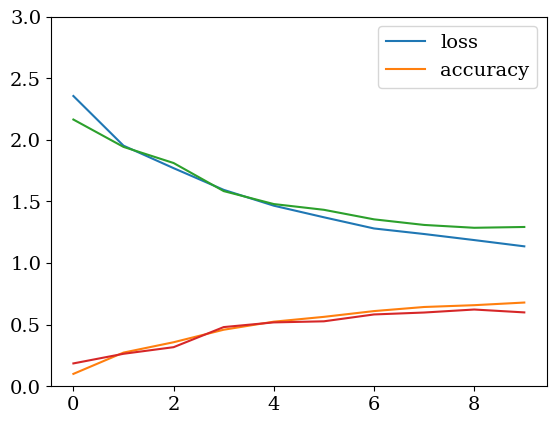

In [35]:
plt.plot(loss_list_deepqfl)
plt.plot(acc_list_deepqfl)
plt.plot(loss_listfedavg)
plt.plot(acc_listfedavg)
plt.legend(['loss', 'accuracy'])
plt.ylim(0, 3)
plt.show()


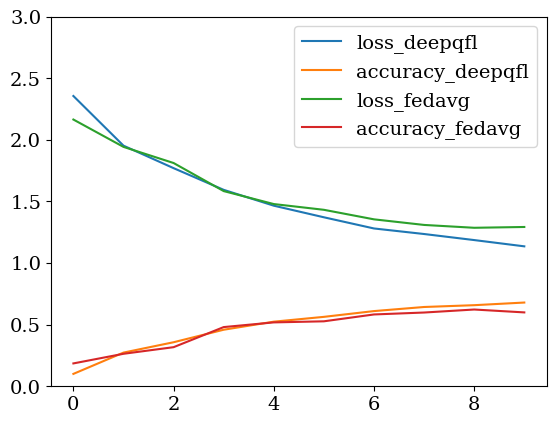

In [36]:
# prompt: give separate legands

# plot the data
plt.plot(loss_list_deepqfl, label='loss_deepqfl')
plt.plot(acc_list_deepqfl, label='accuracy_deepqfl')
plt.plot(loss_listfedavg, label='loss_fedavg')
plt.plot(acc_listfedavg, label='accuracy_fedavg')

plt.legend()
plt.ylim(0, 3)
plt.show()


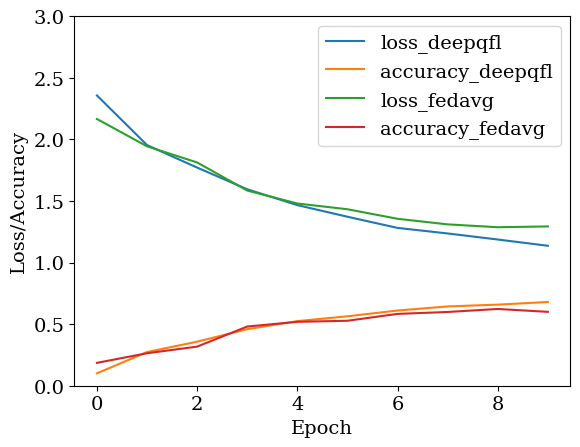

In [37]:
# prompt: give x axis and y axis labels

# plot the data
plt.plot(loss_list_deepqfl, label='loss_deepqfl')
plt.plot(acc_list_deepqfl, label='accuracy_deepqfl')
plt.plot(loss_listfedavg, label='loss_fedavg')
plt.plot(acc_listfedavg, label='accuracy_fedavg')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.ylim(0, 3)
plt.show()


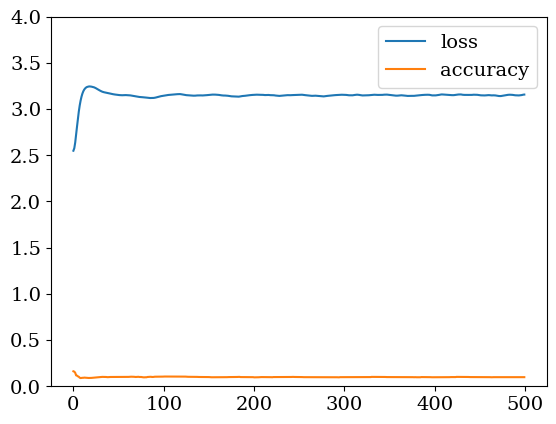

In [17]:
plt.plot(loss_list)
plt.plot(acc_list)
plt.legend(['loss', 'accuracy'])
plt.ylim(0, 4)
plt.show()


In [ ]:
import csv

with open('fedavg_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'loss', 'accuracy'])
    for i in range(len(loss_listfedavg)):
        writer.writerow([i, loss_list_deepqfl[i], acc_list_deepqfl[i]])

In [44]:

params_list = [] #store parameters
opt_state_list = []#optimization states
data_list = []#datasets
iter_list = []#iterators for each node

for node in tqdm(range(n_node-1)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    data = tf.data.Dataset.from_tensor_slices((x_train_node, y_train_node)).batch(64)
    data_list.append(data)
    iter_list.append(iter(data)) #The iterator is used to iterate over batches during the training loop.

    key, subkey = jax.random.split(key)
    params = jax.random.normal(subkey, (3 * k, n))
    opt = optax.adam(learning_rate=1e-2)
    opt_state = opt.init(params)
    params_list.append(params)
    opt_state_list.append(opt_state)

loss_list = []
acc_list = []
for e in tqdm(range(10), leave=False):
    for b in range(5): #number of batches one include 16 data points
        for node in range(n_node-1):
            try:
                x, y = next(iter_list[node])
            except StopIteration:
                iter_list[node] = iter(data_list[node])
                x, y = next(iter_list[node])
            x = x.numpy()
            y = y.numpy()
            loss_val, grad_val = compute_loss(params_list[node], x, y, k)
            updates, opt_state_list[node] = opt.update(grad_val, opt_state_list[node], params_list[node])
            params_list[node] = optax.apply_updates(params_list[node], updates)

        avg_params = jnp.mean(jnp.stack(params_list, axis=0), axis=0)



        for node in range(n_node-1):
            params_list[node] = avg_params

        if b % 1 == 0:
            avg_loss = jnp.mean(compute_loss(avg_params, x_test[:1024], y_test[:1024], k)[0])
            loss_list.append(avg_loss)
            acc_list.append(compute_accuracy(avg_params, x_test[:1024], y_test[:1024], k).mean())
            print(f"Epoch {e}, batch {b}/{1}, loss {avg_loss}, accuracy {acc_list[-1]}")



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, batch 0/1, loss 2.4629054069519043, accuracy 0.107421875
Epoch 0, batch 1/1, loss 2.4588847160339355, accuracy 0.111328125
Epoch 0, batch 2/1, loss 2.455557346343994, accuracy 0.1171875
Epoch 0, batch 3/1, loss 2.452803373336792, accuracy 0.123046875
Epoch 0, batch 4/1, loss 2.4510412216186523, accuracy 0.1279296875
Epoch 1, batch 0/1, loss 2.449622869491577, accuracy 0.1328125
Epoch 1, batch 1/1, loss 2.448868751525879, accuracy 0.1357421875
Epoch 1, batch 2/1, loss 2.449286699295044, accuracy 0.134765625
Epoch 1, batch 3/1, loss 2.4498696327209473, accuracy 0.1396484375
Epoch 1, batch 4/1, loss 2.4517414569854736, accuracy 0.1435546875
Epoch 2, batch 0/1, loss 2.4552316665649414, accuracy 0.1494140625
Epoch 2, batch 1/1, loss 2.4590108394622803, accuracy 0.15234375
Epoch 2, batch 2/1, loss 2.4640378952026367, accuracy 0.1494140625
Epoch 2, batch 3/1, loss 2.469797134399414, accuracy 0.150390625
Epoch 2, batch 4/1, loss 2.476210594177246, accuracy 0.146484375
Epoch 3, batch 0

In [31]:
print(normalized_weights.shape)
print(node)


(8, 8)
0


In [22]:
# prompt: How to get the sum of param_lists for each node and get the noramlized sum

# Calculate the sum of param_lists for each node
node_sums = jnp.sum(jnp.stack(params_lists, axis=0), axis=1)

# Normalize the sum to obtain the normalized weights for each node
normalized_weights = node_sums / jnp.sum(node_sums)

# Print the normalized weights for each node
for node in range(n_node):
    print(f"Normalized weight for node {node}: {normalized_weights[node]}")



TypeError: stack requires ndarray or scalar arguments, got <class 'list'> at position 0.

In [ ]:
# prompt: get only one value for each node by using all the corresponding parameters per node, and then to use that value as the node's contribution values for federated learning process?

# Calculate the weighted average of the parameters for each node
weighted_average_params = []
for node in range(n_node):
    weighted_average_params.append(
        jnp.average(
            jnp.stack(params_lists, axis=0),
            weights=normalized_weights[node],
            axis=0,
        )
    )

# Use the weighted average parameters for federated learning
# ...


In [ ]:
# prompt: I need to print them

print(node_sums)
print(normalized_weights)
print(weighted_average_params)


DEEP UNFOLDING to assig weights

In [ ]:
#Preprocessing Framework here


In [39]:
def deepUnfoldweights(deepunfold_iterations,quibits):

  n=quibits

  M=deepunfold_iterations
  i=0
  key = jax.random.PRNGKey(0)

  for loop in range (M):
    i=i+1
    print("Start deep unfolding layer", {loop})

    params_list = [] #store parameters
    opt_state_list = []#optimization states
    data_list = []#datasets
    iter_list = []#iterators for each node

    for node in tqdm(range(n_node-1)):
      print("Assign data and parameter initialization", {node})
      x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
      data = tf.data.Dataset.from_tensor_slices((x_train_node, y_train_node)).batch(16)
      data_list.append(data)
      iter_list.append(iter(data)) #The iterator is used to iterate over batches during the training loop.

      key, subkey = jax.random.split(key)
      params = jax.random.normal(subkey, (3 * k, n))
      opt = optax.adam(learning_rate=1e-2)

      opt_state = opt.init(params)
      params_list.append(params)
      opt_state_list.append(opt_state)

    #FL process in each block
    params_lists=[]
    problist=[]
    targetlist=[]

    problists=[]
    targetlists=[]
    for e in tqdm(range(1), leave=False):
      for b in range(10):
        for node in range(n_node-1):
          try:
              x, y = next(iter_list[node])
          except StopIteration:
              iter_list[node] = iter(data_list[node])
              x, y = next(iter_list[node])
          x = x.numpy()
          y = y.numpy()
          loss_val, grad_val = compute_loss(params_list[node], x, y, k)
          targetlist.append(y)

          #get probability measurement/expectation values by calling readout
          c = tc.Circuit(n, inputs=x)
          c = clf(params, c, k)
          probs = readout(c)
          problist.append(probs)

          updates, opt_state_list[node] = opt.update(grad_val, opt_state_list[node], params_list[node])
          params_list[node] = optax.apply_updates(params_list[node], updates)

        avg_params = jnp.mean(jnp.stack(params_list, axis=0), axis=0)
        for node in range(n_node-1):
            params_list[node] = avg_params

    params_lists.append(params_list)
    updates, opt_state_list[node] = opt.update(grad_val, opt_state_list[node], params_lists)
    params_lists = optax.apply_updates(params_lists, updates)
    #initialize optimizer values

    #Loss calculation

    #Optimize by steps
    #probvlaues,problist, problists
    #return problists

  #loss gradient and minimization

# calculates node weights propotion to Weighted sum for each node
#save them in a dictionary

    # Assuming params_lists is a list of lists where params_lists[i][j] represents weights for client i at iteration j
# Each sublist should have the same length (number of iterations)

# Step 1: Sum the weights for each client across all iterations
  client_sums = jnp.sum(jnp.stack(params_lists, axis=0), axis=1)

# Step 2: Normalize the sum to obtain the normalized weights for each client
  normalized_weights = client_sums / jnp.sum(client_sums)
  return normalized_weights


#for node in tqdm(range(n_node-1)):
      #need to modify bit
    ## Assuming you have a node_weights array representing the weights for each node
    #weighted_average_params_sum = jnp.mean(jnp.stack(params_lists[node], axis=0) *normalized_weights[node], axis=0)

print("Deep unfolding done", flush=True)

Deep unfolding done


In [ ]:
normalized_weights=deepUnfoldweights(10,8)

Start deep unfolding layer {0}


  0%|          | 0/7 [00:00<?, ?it/s]

Assign data and parameter initialization {0}
Assign data and parameter initialization {1}
Assign data and parameter initialization {2}
Assign data and parameter initialization {3}
Assign data and parameter initialization {4}
Assign data and parameter initialization {5}
Assign data and parameter initialization {6}


  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import jax
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.mixture import GaussianMixture

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rc('font', size=14)

K = tc.set_backend('jax')
key = jax.random.PRNGKey(42)
tf.random.set_seed(42)

n_world = 10

dataset = 'mnist'
# dataset = 'fashion'
readout_mode = 'softmax'
# readout_mode = 'sample'
encoding_mode = 'vanilla'
# encoding_mode = 'mean'
# encoding_mode = 'half'

n = 8
n_node = 8
k = 48

def filter(x, y, class_list):
    keep = jnp.zeros(len(y)).astype(bool)
    for c in class_list:
        keep = keep | (y == c)
    x, y = x[keep], y[keep]
    y = jax.nn.one_hot(y, n_node)
    return x, y

def clf(params, c, k):
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[3 * j, i])
            c.rz(i, theta=params[3 * j + 1, i])
            c.rx(i, theta=params[3 * j + 2, i])
    return c

def readout(c):
    if readout_mode == 'softmax':
        logits = []
        for i in range(n_node):
            logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
        logits = jnp.stack(logits, axis=-1) * 10
        probs = jax.nn.softmax(logits)
    elif readout_mode == 'sample':
        wf = jnp.abs(c.wavefunction()[:n_node])**2
        probs = wf / jnp.sum(wf)
    return probs

def loss(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return -jnp.mean(jnp.sum(y * jnp.log(probs + 1e-7), axis=-1))
loss = K.jit(loss, static_argnums=[3])

def accuracy(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return jnp.argmax(probs, axis=-1) == jnp.argmax(y, axis=-1)
accuracy = K.jit(accuracy, static_argnums=[3])

compute_loss = K.jit(K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2]), static_argnums=[3])
compute_accuracy = K.jit(K.vmap(accuracy, vectorized_argnums=[1, 2]), static_argnums=[3])

def pred(params, x, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return probs
pred = K.vmap(pred, vectorized_argnums=[1])

if __name__ == '__main__':
    # numpy data
    if dataset == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif dataset == 'fashion':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    ind = y_test == 9
    x_test, y_test = x_test[~ind], y_test[~ind]
    ind = y_test == 8
    x_test, y_test = x_test[~ind], y_test[~ind]
    ind = y_train == 9
    x_train, y_train = x_train[~ind], y_train[~ind]
    ind = y_train == 8
    x_train, y_train = x_train[~ind], y_train[~ind]

    x_train = x_train / 255.0
    if encoding_mode == 'vanilla':
        mean = 0
    elif encoding_mode == 'mean':
        mean = jnp.mean(x_train, axis=0)
    elif encoding_mode == 'half':
        mean = 0.5
    x_train = x_train - mean
    x_train = tf.image.resize(x_train[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
    x_train = x_train / jnp.sqrt(jnp.sum(x_train**2, axis=-1, keepdims=True))

    x_test = x_test / 255.0
    x_test = x_test - mean
    x_test = tf.image.resize(x_test[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
    x_test = x_test / jnp.sqrt(jnp.sum(x_test**2, axis=-1, keepdims=True))
    y_test = jax.nn.one_hot(y_test, n_node)

    world_train_loss = []
    world_test_loss = []
    world_train_acc = []
    world_test_acc = []
    for world in tqdm(range(n_world)):

        params_list = []
        opt_state_list = []
        data_list = []
        iter_list = []
        for node in range(n_node-1):
            x_train_node, y_train_node = filter(x_train, y_train, [0, node+1])
            # x_train_node, y_train_node = x_train, jax.nn.one_hot(y_train, n_node)
            data = tf.data.Dataset.from_tensor_slices((x_train_node, y_train_node)).batch(128)
            data_list.append(data)
            iter_list.append(iter(data))

            key, subkey = jax.random.split(key)
            params = jax.random.normal(subkey, (3 * k, n))
            opt = optax.adam(learning_rate=1e-2)
            opt_state = opt.init(params)
            params_list.append(params)
            opt_state_list.append(opt_state)

        loss_list = []
        acc_list = []
        for e in tqdm(range(5), leave=False):
            for b in range(100):
                for node in range(n_node-1):
                    try:
                        x, y = next(iter_list[node])
                    except StopIteration:
                        iter_list[node] = iter(data_list[node])
                        x, y = next(iter_list[node])
                    x = x.numpy()
                    y = y.numpy()
                    loss_val, grad_val = compute_loss(params_list[node], x, y, k)
                    updates, opt_state_list[node] = opt.update(grad_val, opt_state_list[node], params_list[node])
                    params_list[node] = optax.apply_updates(params_list[node], updates)

                avg_params = jnp.mean(jnp.stack(params_list, axis=0), axis=0)
                for node in range(n_node-1):
                    params_list[node] = avg_params

                if b % 25 == 0:
                    avg_loss = jnp.mean(compute_loss(avg_params, x_test[:1024], y_test[:1024], k)[0])
                    loss_list.append(avg_loss)
                    acc_list.append(compute_accuracy(avg_params, x_test[:1024], y_test[:1024], k).mean())
                    tqdm.write(f"world {world}, epoch {e}, batch {b}/{100}: loss {avg_loss}, accuracy {acc_list[-1]}")

        test_acc = jnp.mean(pred(avg_params, x_test[:1024], k).argmax(axis=-1) == y_test[:1024].argmax(axis=-1))
        test_loss = -jnp.mean(jnp.log(pred(avg_params, x_test[:1024], k)) * y_test[:1024])

        world_train_loss.append(loss_list)
        world_test_loss.append(test_loss)
        world_train_acc.append(acc_list)
        world_test_acc.append(test_acc)
        tqdm.write(f"world {world}: test loss {test_loss}, test accuracy {test_acc}")

    os.makedirs(f'./{dataset}/qFedAvg/', exist_ok=True)
    jnp.save(f'./{dataset}/qFedAvg/train_loss.npy', world_train_loss)
    jnp.save(f'./{dataset}/qFedAvg/train_acc.npy', world_train_acc)
    jnp.save(f'./{dataset}/qFedAvg/test_loss.npy', world_test_loss)
    jnp.save(f'./{dataset}/qFedAvg/test_acc.npy', world_test_acc)

    avg_test_loss = jnp.mean(jnp.array(world_test_loss), axis=0)
    avg_test_acc = jnp.mean(jnp.array(world_test_acc), axis=0)
    std_test_loss = jnp.std(jnp.array(world_test_loss), axis=0)
    std_test_acc = jnp.std(jnp.array(world_test_acc), axis=0)
    print(f'test loss: {avg_test_loss}+-{std_test_loss}, test acc: {avg_test_acc}+-{std_test_acc}')

  0%|          | 0/10 [36:16<?, ?it/s]


KeyboardInterrupt: 